In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/My Drive/fyp1"

/content/gdrive/My Drive/fyp1


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim

import random
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import json
from sklearn.metrics import auc, roc_curve, precision_recall_curve

In [ ]:
print(torch.__version__)

1.13.0+cu116


---
# 1. Model

In [ ]:
class Contrastive_head(nn.Module):
    def __init__(self, num_center=2, in_channels=32, lambda_1=0.0001, beta=0.0001, m=1.25):
        super().__init__()
        
        self.num_class = 2
        self.num_center = num_center #number of center per class
        self.in_channels = in_channels
        self.lambda_1 = lambda_1
        self.beta = beta
        self.m = torch.tensor(m)
        self.Centers = nn.Parameter(torch.randn(2, num_center, self.in_channels), requires_grad=True) #(nclass,ncenter,c)

    def forward(self, x, device):
        #x = (b*3,c,k)
        #top 3 score from normal video
        #last 3 score from anomaly video
        #top 3 score from anomaly video
        
        # compute intra distance
        intra_distance = torch.mean(self.compute_intra_dist(x[:int(x.shape[0]/3)], self.Centers[0]) + \
                                    self.compute_intra_dist(x[int(x.shape[0]/3):int(x.shape[0]/3*2)], self.Centers[0]) + \
                                    self.compute_intra_dist(x[int(x.shape[0]/3*2):], self.Centers[1]))
        
        # compute inter distance
        inter_distance = self.compute_inter_dist(self.Centers[0], self.Centers[1], self.m, device) 

        # compute multicenter loss
        mc_loss = self.lambda_1 * intra_distance + self.beta * inter_distance

        return mc_loss

    def compute_intra_dist(self, x, centers):
        #x = (b,c,nsegment)
        centers2 = centers.repeat(x.shape[0], x.shape[2], 1, 1)
        #centers2 = (b, nsegment, ncenter, c)
        centers2 = centers2.permute(2,0,3,1)
        #centers2 = (ncenter,b,c,nsegment)
        dist_ctr_fea = (centers2 - x).square().sum(dim=2).sqrt()
        #dist_ctr_fea = (ncenter, b, nsegment)    
        min_dist_fea_ctr, idx = torch.min(dist_ctr_fea, dim=0)
        #min_dist_fea_ctr = (b, nsegment)
        sum_dist_fea_ctr = torch.mean(min_dist_fea_ctr, dim=1)
        #sum_dist_fea_ctr = (b)
        return sum_dist_fea_ctr

    def compute_inter_dist(self, norm_centers, anom_centers, m, device):
        #norm_centers = (ncenter, c)
        #anom_centers = (ncenter, c)
        total_ctr = norm_centers.shape[0] + anom_centers.shape[0] # (ncenter+ncenter)
        centers = torch.cat((norm_centers, anom_centers), dim=0)
        #centers = (ncenter+ncenter, c)
        centers2 = centers.unsqueeze(0)
        #centers = (1, ncenter, c)
        dist = torch.cdist(centers2, centers2).squeeze()
        #dist = (total_ctr,total_ctr)
        margin = m.repeat(dist.shape[0], dist.shape[1]) #margin2 = (total_ctr,total_ctr)
        margin = margin.to(device)
        zeros = torch.zeros_like(dist) #zeros = (total_ctr,total_ctr)
        zeros = zeros.to(device)
        inter_dist = torch.max(zeros, margin-dist).sum() / (total_ctr*(total_ctr-1)) 
        return inter_dist

In [ ]:
# Reference: https://amaarora.github.io/2020/09/13/unet.html

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch        
        
        self.conv1 = nn.Conv1d (in_ch, out_ch, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=5, stride=1, padding=2)        
        self.conv3 = nn.Conv1d(out_ch, out_ch, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        r = x
        r = self.conv2(r)
        r = F.relu(r)
        r = self.conv3(r)
        x = x + r
        x = F.relu(x)
        return x
        
class Encoder(nn.Module):
    def __init__(self, in_channels, blk_channels):
        super().__init__()
        self.in_channels = in_channels
        self.blk_channels = blk_channels
        channels = [in_channels] + list(blk_channels)
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
    def forward(self, x):
        enc_out = []
        for i, block in enumerate(self.enc_blocks):
            x = block(x)
            enc_out.append(x)
            if i < len(self.enc_blocks)-1:
                x = F.max_pool1d(x, 2, 2)
        return enc_out
    
class Decoder(nn.Module):
    def __init__(self, blk_channels):
        super().__init__()
        self.channels = blk_channels[::-1]  # reverse the blk_channels
        self.upconvs = nn.ModuleList ([nn.ConvTranspose1d(self.channels[i], self.channels[i+1], kernel_size=2, stride=2) 
                                       for i in range(len(self.channels)-1)])
        self.dec_blocks = nn.ModuleList([Block(self.channels[i]*2, self.channels[i+1]) 
                                         for i in range(len(self.channels)-1)]) 
        
    def crop(self, enc_fea, x):
        _, _, L = x.shape
        _, _, Le = enc_fea.shape
        start = (Le - L)//2
        return enc_fea[:,:, start:start+L]
        
    def forward(self, enc_out, inputs):
        enc_out = enc_out[::-1]  # reverse the order
        x = enc_out[0]
        enc_out = enc_out[1:]
        for i in range(len(self.channels)-1):
            x1 = self.upconvs[i](x)
            x2 = self.crop(enc_out[i], x1)
            x = torch.cat([x1, x2], dim=1)
            x = self.dec_blocks[i](x)
        x = F.interpolate(x, inputs.shape[-1])
        return x
    
class Head(nn.Module):
    def __init__ (self, channels):
        super().__init__()
        self.layers = nn.ModuleList([nn.Conv1d(channels[i], channels[i+1], kernel_size=1) for i in range(len(channels)-1)])
        self.dropout = nn.Dropout(p=0.7) 
        
    def forward(self, x, isTraining):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers) - 1:
                x = torch.sigmoid(x)
            else:
                x = F.relu(x)
                if isTraining == True:
                    x = self.dropout(x)
                last_fea = x
        return last_fea, x
        
class Model(nn.Module):
    def __init__(self, in_channels=1024, 
                 blk_channels  = (1024, 1024, 1024, 1024),  
                 head_channels = (1024, 512, 32, 1)):
        super().__init__()
        self.in_channels  = in_channels
        self.blk_channels = blk_channels
        self.encoder = Encoder(in_channels, blk_channels)
        self.decoder = Decoder(blk_channels)
        self.head    = Head(head_channels)
        self.contrastive_head = Contrastive_head(num_center=16, in_channels=32, lambda_1=0.00224, beta=0.2304, m=1.25)

    def forward(self, inputs, isTraining=False, device="cpu"):
        #inputs = (b*2,c,nsegment):(?,1024,32)
        enc_output = self.encoder(inputs)               
        dec_output = self.decoder(enc_output, inputs)      
        last_fea, segment_scores = self.head(dec_output, isTraining)
        #last_fea = (b*2, 32, nsegment), features just before classification layer
        #segment_scores = (b*2, 1, nsegment)
        if isTraining == True:
            """#============= loss function =============="""
            bce, idx_topK_anom, idx_lastK_anom, idx_topK_norm = self.myLossFunction(segment_scores)
            #idx_topK_anom = (b,ksegment)

            """#============== get topk & lastk feature ===================="""
            last_fea = last_fea.to("cpu")
            last_fea = last_fea.permute(1,0,2) #convert (b*2, 32, nsegment) to (32, b*2, nsegment)
            normal_features = last_fea[:,:int(last_fea.shape[1]/2)] #segment feature in normal video 
            anomaly_features = last_fea[:,int(last_fea.shape[1]/2):] #segment feature in anomaly video 
            #normal_features = (32, b, nsegment)
            #anomaly_features = (32, b, nsegment)

            total_topk_norm_feature = torch.zeros(0)
            total_topk_abn_feature = torch.zeros(0)
            total_lastk_abn_feature = torch.zeros(0)
            #get topk features from normal video
            for normal_feature in normal_features: 
                topk_norm_feature = torch.gather(normal_feature, 1, idx_topK_norm)     
                #topk_norm_feature = (b,k)
                topk_norm_feature = torch.unsqueeze(topk_norm_feature, 0)
                #topk_norm_feature = (1,b,k)
                total_topk_norm_feature = torch.cat((total_topk_norm_feature, topk_norm_feature), dim=0)  

            #get topk and lastk features from anomaly video
            for abnormal_feature in anomaly_features: 
                topk_abn_feature = torch.gather(abnormal_feature, 1, idx_topK_anom)  
                lastk_abn_feature = torch.gather(abnormal_feature, 1, idx_lastK_anom)   
                #topk_abn_feature = (b,k)
                topk_abn_feature = torch.unsqueeze(topk_abn_feature, 0)
                lastk_abn_feature = torch.unsqueeze(lastk_abn_feature, 0)
                #topk_abn_feature = (1,b,k)
                total_topk_abn_feature = torch.cat((total_topk_abn_feature, topk_abn_feature), dim=0)  
                total_lastk_abn_feature = torch.cat((total_lastk_abn_feature, lastk_abn_feature), dim=0) 
            
            #total_topk_norm_feature = (c,b,k)
            #total_topk_abn_feature = (c,b,k)
            #total_lastk_abn_feature = (c,b,k)
            selected_feature = torch.cat((total_topk_norm_feature, total_lastk_abn_feature, total_topk_abn_feature), dim=1) #first half is lastK features, second half is topK features 
            selected_feature = selected_feature.permute(1,0,2) #convert (c,b*3,k) to (b*3,c,k)
            selected_feature = selected_feature.to(device)
            """#============== contrastive regularization =====================""" 
            mc_loss = self.contrastive_head(selected_feature, device)
            combination_loss = bce + mc_loss
            return combination_loss
        else:
            return last_fea, segment_scores 
            #last_fea = (b*2, c, nsegment)
            #segment_scores=(b*2, 1, nsegment)

    def myLossFunction(self, segment_scores, k=3, lambda_1=0.00008, lambda_2=0.00008):
        #convert (b,1,nsegment) to (b,nsegment)
        segment_scores = torch.squeeze(segment_scores, 1) 

        #to cpu
        segment_scores = segment_scores.to("cpu")

        #segment_scores = (b*2, nsegment)
        normal_scores = segment_scores[:int(segment_scores.shape[0]/2)]
        #normal_scores (b,nsegment)

        anomaly_scores = segment_scores[int(segment_scores.shape[0]/2):]
        #anomaly_scores (b,nsegment)
        #========== get top-k segment score ============
        topk_norm_scores, idx_topK_norm = torch.topk(normal_scores, k=k, dim=1, largest=True)   #top-k normal score (b,k)
        topk_anom_scores, idx_topK_anom = torch.topk(anomaly_scores, k=k, dim=1, largest=True) #top-k anomaly score (b,k)
        _, idx_lastK_anom = torch.topk(anomaly_scores, k=k, dim=1, largest=False) #last-k anomaly score (b,k)
        topk_scores = torch.cat((topk_norm_scores, topk_anom_scores), dim=0) #(b*2,k)

        #initialize label
        zeros = torch.zeros_like(topk_norm_scores) #(b,k)
        ones = torch.ones_like(topk_anom_scores) #(b,k)
        label = torch.cat((zeros, ones), dim=0) #(b*2,k)

        #=========== binary cross entropy loss ====================
        bce = F.binary_cross_entropy(topk_scores, label)  

        anomaly_scores = anomaly_scores.permute(1,0) #(nsegment,b)
        normal_scores = normal_scores.permute(1,0) #(nsegment,b)
        
        #========= get temporal smoothness ==========
        diff_neighbour = torch.randn(anomaly_scores.shape[0]-1, anomaly_scores.shape[1]) # (nsegment-1, b) difference of 2 neighbour segment
        for i in range(anomaly_scores.shape[0]-1): # #segments-1
            diff_neighbour[i] = torch.pow((anomaly_scores[i] - anomaly_scores[i+1]), 2) 

        temp_smoothness = lambda_1 * torch.sum(diff_neighbour, dim=0, keepdim=True) 

        #========= get sparsity ==========
        sparsity = lambda_2 * torch.sum(anomaly_scores, dim=0, keepdim=True) #(1, b)

        #final cost 
        cost = bce + torch.mean(temp_smoothness) + torch.mean(sparsity) 

        return cost, idx_topK_anom, idx_lastK_anom, idx_topK_norm

---
# 2. plot AUC graph

In [ ]:
def evaluate(model, test_dir, annotation_txt):
    with open('./groundtruths.json', 'rb') as fp:
        groundtruths = json.load(fp)

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model = model.to(device)
    model.eval()

    pred_scores = torch.zeros(69589) #used to store the clip-level score for every test videos. 69589 clips, 1113424 frames
    idx = 0
    #=============== load feature according to the order in annotation file ================
    f = open(annotation_txt, "r")
    for line in f: 
        #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
        annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
        video_name = annotation[0][:-4] #Abuse028_x264

        #============ combine version0~9 into 1 tensor =====================
        for i in range(10):
            path = os.path.join(test_dir, video_name+"_version"+str(i)+".pt")

            #================== load feature =====================
            x = torch.load(path, map_location=device) 
            #x = (c,nclip):(1024,?) 
            if i == 0:
                fea_clip = torch.randn((10,1024, x.shape[1]), device=device)
                #fea_clip = (ncrop,c,nclip):(10,1024,?)
            fea_clip[i] = x

        #fea_clip = (ncrop,c,nclip):(10,1024,?)
        with torch.no_grad():
            fea, scores = model(fea_clip)
            #score = (ncrop,1,nclip)
        scores = scores.to("cpu")
        scores = torch.squeeze(scores)
        #score = (ncrop,nclip)
        #================= mean ======================
        scores = torch.mean(scores, dim=0)
        #scores = (nclip,)

        #store predicted clip-level scores for current video
        pred_scores[idx:idx+scores.shape[0]] = scores[:] #pred_scores = torch.cat((pred_scores, scores))
        idx += scores.shape[0]
    f.close()
    if idx != pred_scores.shape[0]:
        raise Exception(f"idx != pred_scores, idx={idx}, pred score={pred_scores.shape[0]}")
    #expand the clip-level scores to frame-level scores for all video
    pred_scores = np.repeat(np.array(pred_scores), 16) #should have 1113424
    return pred_scores

In [ ]:
def roc_auc(pred, gt_json="./groundtruths.json", showGraph=False):
    with open(gt_json, 'rb') as fp:
        gt = json.load(fp)
    fpr, tpr, threshold = roc_curve(list(gt), pred)
    myAUC = auc(fpr, tpr)

    if showGraph == True:
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return myAUC

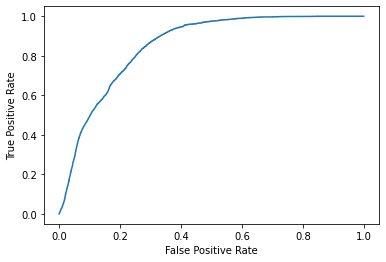

auc = 0.8524


In [ ]:
#================= setting ============================
saved_weight = "./saved_model/top3pos_last3pos_top3neg_16centers_L0.00256_m1.25_b0.2304_1024c_B64/highestAUC.pt" #85.24
#==================================================

model = Model()
model.load_state_dict(torch.load(saved_weight, map_location='cuda:0'))

pred_scores = evaluate(model, test_dir="./feature_extracted/test/10-crop/", annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt")
running_auc = roc_auc(pred=pred_scores, gt_json="./groundtruths.json", showGraph=True)
print(f'auc = {running_auc:.4f}')

---
#3. AUC for each type of crime

In [ ]:
#calculate nframe for each type
def calculate(dir, annotation_txt, crimeType):
    total_frame = []
    f = open(annotation_txt, "r")
    for line in f: 
        #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
        annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
        video_name = annotation[0] #Abuse028_x264.mp4
        if crimeType not in video_name:
            continue
        video_path = os.path.join(dir, video_name) #Abuse/Abuse028_x264.mp4

        #load video 
        #============== load video ===============
        cap = cv.VideoCapture(video_path)
        #if video cannot open
        if (cap.isOpened()== False):
            raise Exception("Error opening video file")
        nframe = 0
        while(cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            nframe += 1
        print(f"{video_path} ==> {nframe} frames")
        total_frame.append(nframe)
    sum = np.sum(total_frame)
    print(f"sum = {sum}")
    return sum

In [ ]:
def roc_auc(pred, gt_json="./groundtruths.json"):
    with open(gt_json, 'rb') as fp:
        gt = json.load(fp)

    #TODO: hardcode each crime type in frame-level
    #TODO: separate gt and pred to different set
    #[0, nframe1, nframe2] type1 = 0~nframe1, type2 = nframe1~nframe2
    frame_category = []
    for n in range(len(frame_category)-1):
        #n = 0, crime type1
        start_frame = frame_category[n]
        end_frame = frame_category[n+1]
        sub_pred = pred[start_frame:end_frame]
        sub_gt = pred[start_frame:end_frame]

        #for ntype, run code below
        fpr, tpr, threshold = roc_curve(list(sub_gt), sub_pred)
        myAUC = auc(fpr, tpr)
        print(f"Crime type {n} = {myAUC}")


In [ ]:
#================= setting ============================
saved_weight = "./saved_model/top3pos_last3pos_top3neg_16centers_L0.00256_m1.25_b0.2304_1024c_B64/highestAUC.pt" #85.24
#==================================================

model = Model()
model.load_state_dict(torch.load(saved_weight, map_location='cuda:0'))

pred_scores = evaluate(model, test_dir="./feature_extracted/test/10-crop/", annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt")

----
# 3. plot "Distance VS Frame Number" and "Anomaly Score VS Frame Number"

In [ ]:
def compute_min_dist_fea_ctr(x, centers):
    #x = (ncrop,c,nclip)

    with torch.no_grad():
        centers2 = centers.repeat(x.shape[0], x.shape[2], 1, 1)
        #centers2 = (ncrop, nclip, ncenter, c)
        centers2 = centers2.permute(2,0,3,1)
        #centers2 = (ncenter,ncrop,c,nclip)
        dist_ctr_fea = (centers2 - x).square().sum(dim=2).sqrt() 
        #dist_ctr_fea = (ncenter, ncrop, nclip)
        min_dist_fea_ctr, idx = torch.min(dist_ctr_fea, dim=0) #minimum distance between feature and 1 of the normal centers
        #min_dist_fea_ctr = (ncrop, nclip)
        mean_dist_fea_ctr = min_dist_fea_ctr.mean(dim=0)
        #mean_dist_fea_ctr, idx = min_dist_fea_ctr.min(dim=0)

    return mean_dist_fea_ctr #(nclip)

In [ ]:
def evalOneVideo(model, test_dir, video_name):
    """predict scores for a give video"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    model = model.to(device)
    model.eval()

    #============ combine version0~9 into 1 tensor =====================
    for i in range(10):
        path = os.path.join(test_dir, video_name+"_version"+str(i)+".pt")

        #================== load feature =====================
        x = torch.load(path, map_location=device) 
        #x = (c,nclip):(1024,?) 
        if i == 0:
            fea_clip = torch.randn((10,1024, x.shape[1]), device=device)
            #fea_clip = (ncrop,c,nclip):(10,1024,?)
        fea_clip[i] = x

    #fea_clip = (ncrop,c,nclip):(10,1024,?)
    with torch.no_grad():
        fea, scores = model(fea_clip)
        #fea = (ncrop,c,nclip):(10,256,?)
        #score = (ncrop,1,nclip)
    dist_fea_norm_ctr = compute_min_dist_fea_ctr(fea, model.contrastive_head.Centers[0])
    #print("normal center", dist_fea_norm_ctr)
    dist_fea_anom_ctr = compute_min_dist_fea_ctr(fea, model.contrastive_head.Centers[1])
    #print("anomaly center", dist_fea_anom_ctr)
    #print("normal minus anomaly", dist_fea_norm_ctr - dist_fea_anom_ctr)
    dist_fea_norm_ctr = dist_fea_norm_ctr.to("cpu")
    dist_fea_anom_ctr = dist_fea_anom_ctr.to("cpu")
    #dist_fea_norm_ctr = (nclip)
    scores = scores.to("cpu")
    scores = torch.squeeze(scores)
    #score = (ncrop,nclip)
    #================= mean ======================
    scores = torch.mean(scores, dim=0)
    #scores = (nclip,)
    return dist_fea_norm_ctr, dist_fea_anom_ctr, scores


In [ ]:
def plot(y, video_name, annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt", yIsScore=True, y2=None):
    """plot graph for a given scores, annotation"""
    annotations = []
    f = open(annotation_txt, "r")
    for line in f: 
        #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
        annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
        annotations.append(annotation) #store annotation
    f.close()

    #video_name = Abuse028_x264
    #======== plot groundtruth anomaly ==========
    for a in annotations:
        if video_name in a[0]:
            if yIsScore==True:
                min = 0.
                max = 1.
            else:
                min = torch.min(y)
                max = torch.max(y)

            verts = [
            (int(a[4]), min),  # left, bottom
            (int(a[4]), max),  # left, top
            (int(a[6]), max),  # right, top
            (int(a[6]), min),  # right, bottom
            (int(a[4]), min),  # ignored
            ]
            verts2 = [
            (int(a[8]), min),  # left, bottom
            (int(a[8]), max),  # left, top
            (int(a[10]), max),  # right, top
            (int(a[10]), min),  # right, bottom
            (int(a[8]), min),  # ignored
            ]

            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
            ]

            fig, ax = plt.subplots()
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='red', lw=2, alpha=0.5)
            ax.add_patch(patch)
            if a[8]!='-1' and a[10]!='-1':
                path = Path(verts2, codes)
                patch = patches.PathPatch(path, facecolor='red', lw=2, alpha=0.5)
                ax.add_patch(patch)
            break

    #========= plot predict score ===========
    y = np.repeat(np.array(y), 16) #change predicted score from clip-level to frame-level
    x = [(i+1) for i in range(y.shape[0])]
    if yIsScore == True:
        plt.plot(x, y.tolist()) #label="Predicted Anomaly Score"
        ax.set_ylim(0, 1)
        plt.ylabel("Anomaly Score")
        plt.title('Anomaly Score VS Frame Number')
    else:
        plt.plot(x, y.tolist())  #, label="dist_norm - dist_anom"
        ax.set_ylim(np.min(y), np.max(y))
        plt.axhline(y = 0.0, color = 'k', linestyle = 'dashed')
        plt.ylabel("Distance")
        plt.title('Distance VS Frame Number')
    plt.xlabel("Frame Number")
    #plt.legend() #show label
    plt.show()

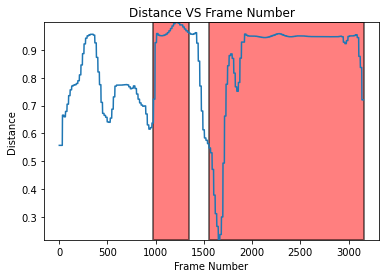

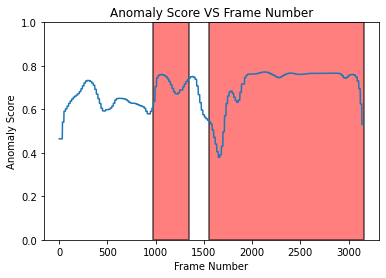

In [ ]:
#=================== setting =========================
saved_weight = "./saved_model/top3pos_last3pos_top3neg_16centers_L0.00256_m1.25_b0.2304_1024c_B64/highestAUC.pt" #85.24
#saved_weight = "./saved_model/top3positiveSample_last3positiveSample_2centers_L0.00008_m1.25_b0.00012_1024c_B64/highestAUC.pt" fyp1 model

test_video = "Explosion033_x264"#"Shooting008_x264" "Shoplifting005_x264" "Shoplifting028_x264" "Burglary037_x264" "Explosion033_x264"
#==================================================
model = Model()
model.load_state_dict(torch.load(saved_weight, map_location='cuda:0'))

#predict score
dist_fea_norm_ctr, dist_fea_anom_ctr, pred_scores = evalOneVideo(model, test_dir="./feature_extracted/test/10-crop/", video_name=test_video)
#plot graph
plot(dist_fea_norm_ctr-dist_fea_anom_ctr, video_name=test_video, annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt", yIsScore=False)
plot(pred_scores, video_name=test_video, annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt", yIsScore=True)

---
# Get graph for all video

In [ ]:
def getAllVideoName(annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt"):
    video_list = []
    f = open(annotation_txt, "r")
    for line in f: 
        #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
        annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
        video_name = annotation[0][:-4] #Abuse028_x264

        video_list.append(video_name)
    return video_list

In [ ]:
video_list = getAllVideoName(annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt")
print(len(video_list))

290


In [ ]:
#=================== setting =========================
saved_weight = "./saved_model/top3pos_last3pos_top3neg_16centers_L0.00256_m1.25_b0.2304_1024c_B64/highestAUC.pt" #85.24
#saved_weight = "./saved_model/top3positiveSample_last3positiveSample_2centers_L0.00008_m1.25_b0.00012_1024c_B64/highestAUC.pt" fyp1 model
#==================================================
model = Model()
model.load_state_dict(torch.load(saved_weight, map_location='cuda:0'))

for test_video in video_list:
    print("==========================================")
    print(test_video)
    #predict score
    dist_fea_norm_ctr, dist_fea_anom_ctr, pred_scores = evalOneVideo(model, test_dir="./feature_extracted/test/10-crop/", video_name=test_video)
    #plot graph
    plot(dist_fea_norm_ctr-dist_fea_anom_ctr, video_name=test_video, annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt", yIsScore=False)
    plot(pred_scores, video_name=test_video, annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt", yIsScore=True)

Output hidden; open in https://colab.research.google.com to view.

---
# 4. t-SNE graph

In [ ]:
import math
def select_feature(model, test_dir, annotation_txt):
    with open('./groundtruths.json', 'rb') as fp:
        groundtruths = json.load(fp)

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        norm_features = torch.randn(30000,32) #(nclip, c)
        curr_norm_idx = 0 
        anom_features = torch.randn(30000,32) #(nclip, c)
        curr_anom_idx = 0 
        #=============== load feature according to the order in annotation file ================
        f = open(annotation_txt, "r")
        for line in f: 
            #eg. line = Abuse028_x264.mp4  Abuse  165  240  -1  -1  
            annotation = line.split(" ") #eg. annotation = ['Abuse028_x264.mp4', '', 'Abuse', '', '165', '', '240', '', '-1', '', '-1', '', '\n']
            
            video_name = annotation[0][:-4] #Abuse028_x264

            #select the center clip (version 5)
            path = os.path.join(test_dir, video_name+"_version"+str(5)+".pt")
            #================== load feature =====================
            x = torch.load(path, map_location=device) 
            x = torch.unsqueeze(x, 0)
            #x = (1, c,nclip):(1, 1024,?) 

            fea, scores = model(x)
            fea = torch.squeeze(fea)
            #score = (1,nclip)
            #fea = (32, nclip)
            fea = fea.permute(1,0) #convert (32,nclip) to (nclip,32)
            """========================= select 2 normal and 2 anomaly clip ===================="""
            idx_anom_start = int(math.floor(int(annotation[4])/16))
            idx_anom_end = int(math.ceil(int(annotation[6])/16))
            
            idx_anom2_start = int(math.floor(int(annotation[8])/16))
            idx_anom2_end = int(math.ceil(int(annotation[10])/16))
            if idx_anom_start != -1:
                #randomly select 2 index from anomaly event
                random_idx = random.randint(idx_anom_start, idx_anom_end)
                random_idx2 = random.randint(idx_anom_start, idx_anom_end)
                while(random_idx2 == random_idx):
                    random_idx2 = random.randint(idx_anom_start, idx_anom_end)
                
                anom_features[curr_anom_idx] = fea[random_idx]
                curr_anom_idx += 1
                anom_features[curr_anom_idx] = fea[random_idx2]
                curr_anom_idx += 1
            
            """randomly select 2 normal clip"""
            random_idx = random.randint(0, fea.shape[0]-1)
            while((random_idx >= idx_anom_start and random_idx <= idx_anom_end) or (random_idx >= idx_anom2_start and random_idx <= idx_anom2_end)):
                random_idx = random.randint(0, fea.shape[0]-1)

            random_idx2 = random.randint(0, fea.shape[0]-1)
            while((random_idx2 >= idx_anom_start and random_idx2 <= idx_anom_end) or (random_idx2 >= idx_anom2_start and random_idx2 <= idx_anom2_end) or (random_idx2 == random_idx)):
                random_idx2 = random.randint(0, fea.shape[0]-1)
            
            norm_features[curr_norm_idx] = fea[random_idx]
            curr_norm_idx += 1
            norm_features[curr_norm_idx] = fea[random_idx2]
            curr_norm_idx += 1
        f.close()

        norm_features = norm_features[:curr_norm_idx]
        anom_features = anom_features[:curr_anom_idx]

    return norm_features, anom_features
    #norm_features = (nclip, 32)
    #anom_features = (nclip, 32)

In [ ]:
from sklearn.manifold import TSNE
def plot_tSNE(norm_centers, anomaly_centers, norm_features, anom_features):
    norm_centers = norm_centers.to("cpu")
    anomaly_centers = anomaly_centers.to("cpu")
    norm_features = norm_features.to("cpu")
    anom_features = anom_features.to("cpu")
    #norm_centers = (ncenter,c)
    #anomaly_centers = (ncenter,c)
    #norm_features = (nclip, c)
    #anom_features = (nclip, c)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    norm_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_features)#(nclip, 3)
    anom_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(anom_features)#(nclip, 3)
    norm_ctr_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_centers)#(ncenter, 3)
    anom_ctr_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(anomaly_centers)#(ncenter, 3)
    
    ctr_embedded = np.concatenate((norm_ctr_embedded, anom_ctr_embedded), axis=0) #(ncenter*2, 3)
    print("ctr_embedded.shape", ctr_embedded.shape)
    #color=['r', 'g', 'b', 'y']
    color=['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
           'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']

    #compare all normal feature with all center
    for i in range(norm_embedded.shape[0]):#loop through each features
        shortest_dist = 10000
        for j in range(ctr_embedded.shape[0]): #loop through each centers
            #calculate distance between features and center
            dist_ctr_fea = np.sqrt(np.sum(np.square(norm_embedded[i] - ctr_embedded[j])))
            #dist_ctr_fea = (norm_embedded[i] - ctr_embedded[j]).square().sum().sqrt() 
            if dist_ctr_fea < shortest_dist:
                shortest_dist = dist_ctr_fea
                closest_ctr = j
        #plot
        ax.scatter(norm_embedded[i,0], norm_embedded[i,1], norm_embedded[i,2], c= color[closest_ctr], s = 100, marker='.', alpha=0.1)
    
    #compare all anomaly feature with all center
    for i in range(anom_embedded.shape[0]):#loop through each features
        shortest_dist = 10000
        for j in range(ctr_embedded.shape[0]): #loop through each centers
            #calculate distance between features and center
            dist_ctr_fea = np.sqrt(np.sum(np.square(anom_embedded[i] - ctr_embedded[j])))
            #dist_ctr_fea = (anom_embedded[i] - ctr_embedded[j]).square().sum().sqrt() 
            print(f"{j}: {dist_ctr_fea}")
            if dist_ctr_fea < shortest_dist:
                shortest_dist = dist_ctr_fea
                closest_ctr = j
        print(f"closest = {closest_ctr}:{shortest_dist}")
        #plot
        ax.scatter(anom_embedded[i,0], anom_embedded[i,1], anom_embedded[i,2], c= color[closest_ctr], s = 100, marker='+', alpha=1)

    plt.show()
    print("Normal center 1~8: blue color")
    print("Normal center 9~16: green color")
    print("Anomaly center 1~8: red color")
    print("Anomaly center 9~16: yellow color")

In [ ]:
from sklearn.manifold import TSNE
def plot_tSNE_2D(norm_centers, anomaly_centers, norm_features, anom_features):
    norm_centers = norm_centers.to("cpu")
    anomaly_centers = anomaly_centers.to("cpu")
    norm_features = norm_features.to("cpu")
    anom_features = anom_features.to("cpu")
    #norm_centers = (ncenter,c)
    #anomaly_centers = (ncenter,c)
    #norm_features = (nclip, c)
    #anom_features = (nclip, c)
    fig = plt.figure()

    norm_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_features)#(nclip, 2)
    anom_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(anom_features)#(nclip, 2)
    norm_ctr_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_centers)#(ncenter, 2)
    anom_ctr_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(anomaly_centers)#(ncenter, 2)
    print(anom_ctr_embedded.shape)
    print(anom_embedded.shape)
    
    ctr_embedded = np.concatenate((norm_ctr_embedded, anom_ctr_embedded), axis=0) #(ncenter*2, 2)
    print("ctr_embedded.shape", ctr_embedded.shape)
    #color=['r', 'g', 'b', 'y']
    color=['#8adbeb', '#5982cf', '#1349ad', '#8adbeb', '#244480', '#41348a', '#4c52ba', '#6065bf', '#4d83b3', '#245682', '#71aee3', '#86b4db', '#a4caeb', '#3e94de', '#73d7ff', '#3157a8',
           '#e8aa99', '#cc5737', '#e8461a', '#f23602', '#8a5954', '#f7530c', '#ed956f', '#e36c54', '#e69787', '#f5734c', '#bf2e02', '#8a2c0f', '#8a0f26', '#a30723', '#f22c50', '#ed6d85']

    #compare all normal feature with all center
    for i in range(norm_embedded.shape[0]):#loop through each features
        shortest_dist = 10000
        for j in range(ctr_embedded.shape[0]): #loop through each centers
            #calculate distance between features and center
            dist_ctr_fea = np.sqrt(np.sum(np.square(norm_embedded[i] - ctr_embedded[j])))
            #dist_ctr_fea = (norm_embedded[i] - ctr_embedded[j]).square().sum().sqrt() 
            if dist_ctr_fea < shortest_dist:
                shortest_dist = dist_ctr_fea
                closest_ctr = j
        #plot
        plt.scatter(norm_embedded[i,0], norm_embedded[i,1], c= color[closest_ctr], s = 100, marker='.', alpha=1)
    
    #compare all anomaly feature with all center
    for i in range(anom_embedded.shape[0]):#loop through each features
        shortest_dist = 10000
        for j in range(ctr_embedded.shape[0]): #loop through each centers
            #calculate distance between features and center
            dist_ctr_fea = np.sqrt(np.sum(np.square(anom_embedded[i] - ctr_embedded[j])))
            #dist_ctr_fea = (anom_embedded[i] - ctr_embedded[j]).square().sum().sqrt() 
            #print(f"{j}: {dist_ctr_fea}")
            if dist_ctr_fea < shortest_dist:
                shortest_dist = dist_ctr_fea
                closest_ctr = j
        #print(f"closest = {closest_ctr}:{shortest_dist}")
        #plot
        plt.scatter(anom_embedded[i,0], anom_embedded[i,1], c= color[closest_ctr], s = 100, marker='+', alpha=1)

    plt.show()
    print("Normal center 1~8: blue color")
    print("Normal center 9~16: green color")
    print("Anomaly center 1~8: red color")
    print("Anomaly center 9~16: yellow color")

In [ ]:
#================= setting ============================
saved_weight = "./saved_model/top3pos_last3pos_top3neg_16centers_L0.00224_m1.25_b0.2304_1024c_B64/highestAUC.pt"
#saved_weight = "./saved_model/top3positiveSample_last3positiveSample_2centers_L0.00008_m1.25_b0.00012_1024c_B64/highestAUC.pt"  model fyp1
#==================================================

model = Model()
model.load_state_dict(torch.load(saved_weight, map_location='cuda:0'))

norm_features, anom_features = select_feature(model, test_dir="./feature_extracted/test/10-crop/", annotation_txt="./Temporal_Anomaly_Annotation_for_Testing_Videos.txt")

In [ ]:
plot_tSNE(model.contrastive_head.Centers[0].detach(), model.contrastive_head.Centers[1].detach(), norm_features.detach(), anom_features.detach())

(16, 2)
(280, 2)
ctr_embedded.shape (32, 2)


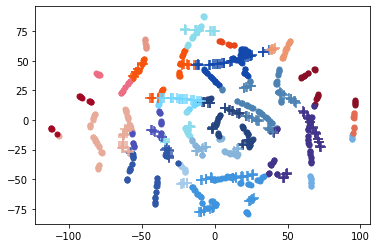

Normal center 1~8: blue color
Normal center 9~16: green color
Anomaly center 1~8: red color
Anomaly center 9~16: yellow color


In [ ]:
plot_tSNE_2D(model.contrastive_head.Centers[0].detach(), model.contrastive_head.Centers[1].detach(), norm_features.detach(), anom_features.detach())

---
# Backup

In [ ]:
def plot_tSNE(norm_centers, anomaly_centers, norm_features, anom_features):
    norm_centers = norm_centers.to("cpu")
    anomaly_centers = anomaly_centers.to("cpu")
    norm_features = norm_features.to("cpu")
    anom_features = anom_features.to("cpu")
    #norm_centers = (ncenter,c)
    #anomaly_centers = (ncenter,c)
    #norm_features = (nclip, c)
    #anom_features = (nclip, c)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    norm_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_features)#(nclip, 3)
    anom_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(anom_features)#(nclip, 3)
    norm_ctr_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(norm_centers)#(ncenter, 3)
    anom_ctr_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(anomaly_centers)#(ncenter, 3)
    
    #plot normal features
    ax.scatter(norm_embedded[:,0], norm_embedded[:,1], norm_embedded[:,2], c= 'b', s = 100, marker='.', alpha=0.01)
    #plot anomaly features
    ax.scatter(anom_embedded[:,0], anom_embedded[:,1], anom_embedded[:,2], c= 'r', s = 100, marker='.', alpha=0.01)
    #plot normal centers
    ax.scatter(norm_ctr_embedded[:,0], norm_ctr_embedded[:,1], norm_ctr_embedded[:,2], c= 'b', s = 300, marker='*')
    #plot anomaly centers
    ax.scatter(anom_ctr_embedded[:,0], anom_ctr_embedded[:,1], anom_ctr_embedded[:,2], c= 'r', s = 300, marker='*')

    """ax.scatter(trans_data[:,0][0:mid], trans_data[:,1][0:mid], trans_data[:,2][0:mid], c= 'r', s = 100, marker='+')
    ax.scatter(trans_data[:,0][mid:], trans_data[:,1][mid:], trans_data[:,2][mid:], c= 'b', s = 100, marker='.')"""

    plt.show()

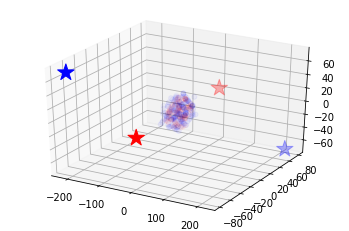

In [ ]:
plot_tSNE(model.contrastive_head.Centers[0].detach(), model.contrastive_head.Centers[1].detach(), norm_features.detach(), anom_features.detach())

torch.Size([2, 32])
torch.Size([2, 32])
torch.Size([580, 32])
torch.Size([280, 32])


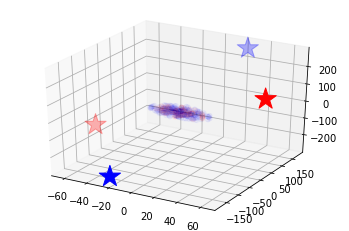

In [ ]:
plot_tSNE(model.contrastive_head.Centers[0].detach(), model.contrastive_head.Centers[1].detach(), norm_features.detach(), anom_features.detach())

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import torch
X = torch.zeros(4,32) #(nclip, c)
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
print(X.shape)
print(X_embedded.shape)

torch.Size([4, 32])
(4, 3)
